# Install needed libraries

In [1]:
!pip install tensorflow==2.3.0
!pip install gym

# Setup the Project

In [2]:
!pip install -e .

Obtaining file:///Users/georgiohelou/Desktop/gym_MLAA
  Attempting uninstall: gym-MLAA
    Found existing installation: gym-MLAA 0.1
    Uninstalling gym-MLAA-0.1:
      Successfully uninstalled gym-MLAA-0.1
  Running setup.py develop for gym-MLAA


In [2]:
!python setup.py install

running install
running bdist_egg
running egg_info
writing gym_maze.egg-info/PKG-INFO
writing dependency_links to gym_maze.egg-info/dependency_links.txt
writing requirements to gym_maze.egg-info/requires.txt
writing top-level names to gym_maze.egg-info/top_level.txt
reading manifest file 'gym_maze.egg-info/SOURCES.txt'
writing manifest file 'gym_maze.egg-info/SOURCES.txt'
installing library code to build/bdist.macosx-10.9-x86_64/egg
running install_lib
running build_py
creating build/bdist.macosx-10.9-x86_64/egg
creating build/bdist.macosx-10.9-x86_64/egg/gym_maze
copying build/lib/gym_maze/__init__.py -> build/bdist.macosx-10.9-x86_64/egg/gym_maze
creating build/bdist.macosx-10.9-x86_64/egg/gym_maze/envs
creating build/bdist.macosx-10.9-x86_64/egg/gym_maze/envs/maze_samples
copying build/lib/gym_maze/envs/maze_samples/maze2d_100x100.npy -> build/bdist.macosx-10.9-x86_64/egg/gym_maze/envs/maze_samples
copying build/lib/gym_maze/envs/maze_samples/maze2d_5x5.npy -> build/bdist.macosx-10.

# Import Needed libraries

In [3]:
import gym 
import random
import sys
import numpy as np
import math

# Import the game environment

In [10]:
import gym_MLAA
env = gym.make('maze-random-10x10-plus-v0')

states = env.observation_space
actions = env.action_space
print(states)
print(actions)

Box([0 0], [9 9], (2,), int64)
Discrete(4)


# Setting Env and Training Constants

In [11]:
'''
Defining the environment related constants
'''
# Number of discrete states (bucket) per state dimension
MAZE_SIZE = tuple((env.observation_space.high + np.ones(env.observation_space.shape)).astype(int))
NUM_BUCKETS = MAZE_SIZE  # one bucket per grid

# Number of discrete actions
NUM_ACTIONS = env.action_space.n  # ["N", "S", "E", "W"]
# Bounds for each discrete state
STATE_BOUNDS = list(zip(env.observation_space.low, env.observation_space.high))

'''
Learning related constants
'''
MIN_EXPLORE_RATE = 0.001
MIN_LEARNING_RATE = 0.2
DECAY_FACTOR = np.prod(MAZE_SIZE, dtype=float) / 10.0

'''
Defining the simulation related constants
'''
NUM_EPISODES = 50000
MAX_T = np.prod(MAZE_SIZE, dtype=int) * 100
STREAK_TO_END = 100
SOLVED_T = np.prod(MAZE_SIZE, dtype=int)
#DEBUG_MODE = 0
RENDER_MAZE = True
ENABLE_RECORDING = True

'''
Creating a Q-Table for each state-action pair
'''
q_table = np.zeros(NUM_BUCKETS + (NUM_ACTIONS,), dtype=float)

'''
Begin simulation
'''
recording_folder = "/tmp/maze_q_learning"


# Define Helper Functions

In [12]:
def select_action(state, explore_rate):
    # Select a random action
    if random.random() < explore_rate:
        action = env.action_space.sample()
    # Select the action with the highest q
    else:
        action = int(np.argmax(q_table[state]))
    return action


def get_explore_rate(t):
    return max(MIN_EXPLORE_RATE, min(0.8, 1.0 - math.log10((t+1)/DECAY_FACTOR)))


def get_learning_rate(t):
    return max(MIN_LEARNING_RATE, min(0.8, 1.0 - math.log10((t+1)/DECAY_FACTOR)))


def state_to_bucket(state):
    bucket_indice = []
    for i in range(len(state)):
        if state[i] <= STATE_BOUNDS[i][0]:
            bucket_index = 0
        elif state[i] >= STATE_BOUNDS[i][1]:
            bucket_index = NUM_BUCKETS[i] - 1
        else:
            # Mapping the state bounds to the bucket array
            bound_width = STATE_BOUNDS[i][1] - STATE_BOUNDS[i][0]
            offset = (NUM_BUCKETS[i]-1)*STATE_BOUNDS[i][0]/bound_width
            scaling = (NUM_BUCKETS[i]-1)/bound_width
            bucket_index = int(round(scaling*state[i] - offset))
        bucket_indice.append(bucket_index)
    return tuple(bucket_indice)

# Q Learning

In [13]:
Q_timeSteps_list = []
Q_TotalReward_list = []
Q_Episodes_list = []

In [14]:
# Instantiating the learning related parameters
learning_rate = get_learning_rate(0)
explore_rate = get_explore_rate(0)
discount_factor = 0.99

num_streaks = 0

# Render tha maze
env.render()

for episode in range(NUM_EPISODES):

    # Reset the environment
    obv = env.reset()

    # the initial state
    state_0 = state_to_bucket(obv)
    action = select_action(state_0, explore_rate)
    total_reward = 0

    for t in range(MAX_T):

        # execute the action
        obv, reward, done, _ = env.step(action)

        # Observe the result
        state = state_to_bucket(obv)
        total_reward += reward
        
        # Select an action
        action = select_action(state_0, explore_rate)

        # Update the Q based on the result
        best_q = np.amax(q_table[state])
        q_table[state_0 + (action,)] += learning_rate * (reward + discount_factor * (best_q) - q_table[state_0 + (action,)])
        #q_table[state_0 + (action,)] += learning_rate * (reward + discount_factor * q_table[state_0 + (action,)] - q_table[state_0 + (action,)])
        
        # Setting up for the next iteration
        state_0 = state

        # Render tha maze
        if RENDER_MAZE:
            env.render()

        if env.is_game_over():
            sys.exit()

        if done:
            print("Episode %d finished after %f time steps with total reward = %f (streak %d)."
                  % (episode, t, total_reward, num_streaks))
            Q_Episodes_list.append(episode)
            Q_timeSteps_list.append(t)
            Q_TotalReward_list.append(total_reward)
            
            if t <= SOLVED_T:
                num_streaks += 1
            else:
                num_streaks = 0
            break

        elif t >= MAX_T - 1:
            print("Episode %d timed out at %d with total reward = %f."
                  % (episode, t, total_reward))

    # It's considered done when it's solved over 120 times consecutively
    if num_streaks > STREAK_TO_END:
        break

    # Update parameters
    explore_rate = get_explore_rate(episode)
    learning_rate = get_learning_rate(episode)

error: display Surface quit

In [29]:
# print(Q_TotalReward_list)
# print(Q_timeSteps_list)
# print(Q_Episodes_list)

# Plot Q-Learning Results

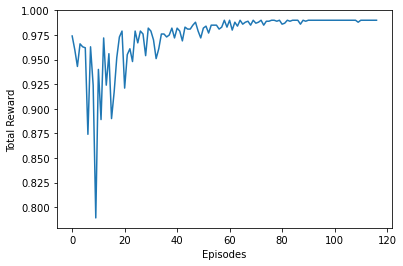

In [16]:
# importing the required module
import matplotlib.pyplot as plt
 
# plotting the points
plt.plot(Q_Episodes_list, Q_TotalReward_list)
 
# naming the x axis
plt.xlabel('Episodes')
# naming the y axis
plt.ylabel('Total Reward')
 
# giving a title to my graph
#plt.title('My first graph!')
 
# function to show the plot
plt.show()

# SARSA

In [20]:
S_timeSteps_list = []
S_TotalReward_list = []
S_Episodes_list = []

In [21]:
# Instantiating the learning related parameters
learning_rate = get_learning_rate(0)
explore_rate = get_explore_rate(0)
discount_factor = 0.99

num_streaks = 0

# Render tha maze
env.render()

for episode in range(NUM_EPISODES):

    # Reset the environment
    obv = env.reset()

    # the initial state
    state_0 = state_to_bucket(obv)
    total_reward = 0

    for t in range(MAX_T):

        # execute the action
        obv, reward, done, _ = env.step(action)

        # Observe the result
        state = state_to_bucket(obv)
        total_reward += reward
        
        # Select an action
        action_new = select_action(state, explore_rate)

        # Update the Q based on the result
        #best_q = np.amax(q_table[state])
        #q_table[state_0 + (action,)] += learning_rate * (reward + discount_factor * (best_q) - q_table[state_0 + (action,)])
        q_table[state_0 + (action,)] += learning_rate * (reward + discount_factor * q_table[state + (action_new,)] - q_table[state_0 + (action,)])
        
        # Setting up for the next iteration
        state_0 = state
        action = action_new

        # Render tha maze
        if RENDER_MAZE:
            env.render()

        if env.is_game_over():
            sys.exit()

        if done:
            print("Episode %d finished after %f time steps with total reward = %f (streak %d)."
                  % (episode, t, total_reward, num_streaks))
            S_Episodes_list.append(episode)
            S_timeSteps_list.append(t)
            S_TotalReward_list.append(total_reward)
            
            if t <= SOLVED_T:
                num_streaks += 1
            else:
                num_streaks = 0
            break

        elif t >= MAX_T - 1:
            print("Episode %d timed out at %d with total reward = %f."
                  % (episode, t, total_reward))

    # It's considered done when it's solved over 120 times consecutively
    if num_streaks > STREAK_TO_END:
        break

    # Update parameters
    explore_rate = get_explore_rate(episode)
    learning_rate = get_learning_rate(episode)

Episode 0 finished after 192.000000 time steps with total reward = 0.808000 (streak 0).
Episode 1 finished after 118.000000 time steps with total reward = 0.882000 (streak 0).
Episode 2 finished after 118.000000 time steps with total reward = 0.882000 (streak 0).
Episode 3 finished after 53.000000 time steps with total reward = 0.947000 (streak 0).
Episode 4 finished after 114.000000 time steps with total reward = 0.886000 (streak 1).
Episode 5 finished after 244.000000 time steps with total reward = 0.756000 (streak 0).
Episode 6 finished after 141.000000 time steps with total reward = 0.859000 (streak 0).
Episode 7 finished after 438.000000 time steps with total reward = 0.562000 (streak 0).
Episode 8 finished after 22.000000 time steps with total reward = 0.978000 (streak 0).
Episode 9 finished after 222.000000 time steps with total reward = 0.778000 (streak 1).
Episode 10 finished after 169.000000 time steps with total reward = 0.831000 (streak 0).
Episode 11 finished after 237.000

Episode 94 finished after 11.000000 time steps with total reward = 0.989000 (streak 69).
Episode 95 finished after 11.000000 time steps with total reward = 0.989000 (streak 70).
Episode 96 finished after 11.000000 time steps with total reward = 0.989000 (streak 71).
Episode 97 finished after 11.000000 time steps with total reward = 0.989000 (streak 72).
Episode 98 finished after 13.000000 time steps with total reward = 0.987000 (streak 73).
Episode 99 finished after 11.000000 time steps with total reward = 0.989000 (streak 74).
Episode 100 finished after 11.000000 time steps with total reward = 0.989000 (streak 75).
Episode 101 finished after 11.000000 time steps with total reward = 0.989000 (streak 76).
Episode 102 finished after 11.000000 time steps with total reward = 0.989000 (streak 77).
Episode 103 finished after 11.000000 time steps with total reward = 0.989000 (streak 78).
Episode 104 finished after 11.000000 time steps with total reward = 0.989000 (streak 79).
Episode 105 fini

# Plot SARSA result

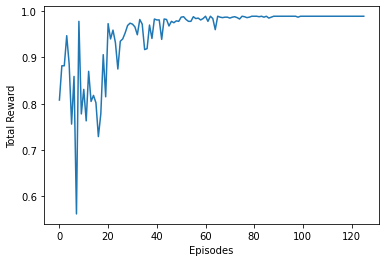

In [22]:
# importing the required module
import matplotlib.pyplot as plt
 
# plotting the points
plt.plot(S_Episodes_list, S_TotalReward_list)
 
# naming the x axis
plt.xlabel('Episodes')
# naming the y axis
plt.ylabel('Total Reward')
 
# giving a title to my graph
#plt.title('My first graph!')
 
# function to show the plot
plt.show()